In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from qiskit import Aer, execute, transpile, IBMQ
from qiskit.circuit import QuantumCircuit, QuantumRegister, AncillaRegister, ClassicalRegister, Parameter, ParameterVector
from qiskit.utils import QuantumInstance
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
import qiskit.quantum_info as qi
from qiskit.circuit.library import GroverOperator, QFT


In [2]:
p = 0.1 #P(X_t = 0 | X_{t-1} = 1) death probability
r = 0.03
# set p_bar s.t. E_bar[X_t] = E[X_t]*exp(-r*t)
p_bar = 1 - (1-p) * np.exp(-r)

#rotation angle corresponding to p_bar
theta_bar = 2*np.arcsin(np.sqrt(1-p_bar))

In [3]:
#theoretical cost under P_bar
cost = 0
for k in range(5):
    cost += (1-p_bar)**(k+1)
cost

3.3926340379889828

In [4]:
#theoretical cost under P
cost2 = 0
for k in range(5):
    cost2 += (1-p)**(k+1) * np.exp(-r*(k+1))
cost2

3.3926340379889837

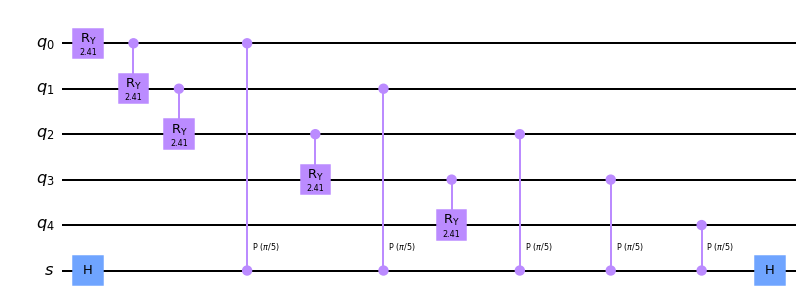

In [5]:
def statePreparation(n_qubits, theta):
    qreg = QuantumRegister(n, 'q')
    qsum = QuantumRegister(1, 's')
    qc = QuantumCircuit(qreg, qsum)

    #assume X_0 = 1, set probability for X_1
    qc.ry(theta,qreg[0])

    #setup transition probabilities
    for k in range(1,n):
        qc.cry(theta, qreg[k-1], qreg[k])

    #average payoff is calculated using a fourier averager
    qc.h(qsum[0])
    for k in range(n):
        qc.cp(np.pi/n, qreg[k], qsum[0])
    qc.h(qsum[0])
    return qc

n = 5
state_preparation = statePreparation(n, theta_bar)
state_preparation.draw('mpl')

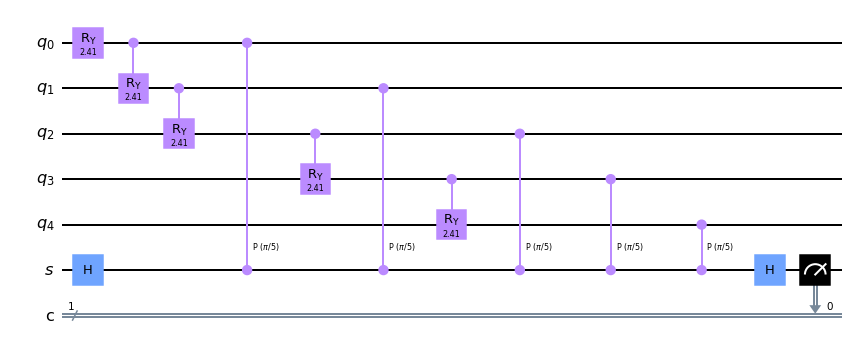

In [6]:
n = 5

qreg = QuantumRegister(n, 'q')
creg = ClassicalRegister(1,'c')
qsum = QuantumRegister(1, 's')
qc = QuantumCircuit(qreg, qsum, creg)

qc.append(state_preparation, qreg[:]+qsum[:])
qc.measure(qsum, creg)
qc.decompose().draw('mpl')

In [7]:
sim_backend = Aer.get_backend('qasm_simulator')
nsim = 2**13
res = execute(qc, sim_backend, shots=nsim).result()
counts = res.get_counts()
sim_avg = counts['1'] / nsim
print(str(sim_avg*n)+' (' + str(n*np.sqrt(sim_avg*(1-sim_avg)/nsim)) + ')')

3.3868408203125 (0.025825041783765497)


In [8]:
from qiskit.algorithms import IterativeAmplitudeEstimation
from qiskit.algorithms import EstimationProblem


quantum_instance = QuantumInstance(sim_backend)
problem = EstimationProblem(
    state_preparation=state_preparation,  # A operator
    objective_qubits=[n],  # the "good" state Psi1 is identified as measuring |1> in qubit 0
)

iae = IterativeAmplitudeEstimation(
    epsilon_target=0.01,  # target accuracy
    alpha=0.05,  # width of the confidence interval
    quantum_instance=quantum_instance,
)
iae_result = iae.estimate(problem)

print("Estimate:", iae_result.estimation*n)

Estimate: 3.3780334860413626


In [9]:
print(*(a*n for a in iae_result.confidence_interval))

3.359869960536111 3.396197011546614


In [10]:
def groverOp(state_preparation, objective_qubit):
    # construct the grover operator
    num_state_qubits = state_preparation.num_qubits - state_preparation.num_ancillas

    oracle = QuantumCircuit(num_state_qubits)
    oracle.h(objective_qubit)
    oracle.x(objective_qubit)
    oracle.h(objective_qubit)

    return GroverOperator(oracle, state_preparation)

def iqft_b(n):
    # inverse QFT
    qr = QuantumRegister(n)
    qc = QuantumCircuit(qr)

    measurement_qubits = range(n)
    for target_qubit in reversed(measurement_qubits):
        for control_qubit in reversed(range(target_qubit+1,n)):
            k = target_qubit - control_qubit - 1
            exponent = -2**(k)
            qc.cp(2*np.pi*exponent, n-control_qubit-1, n-target_qubit-1)
        qc.h(n-target_qubit-1)

    return qc


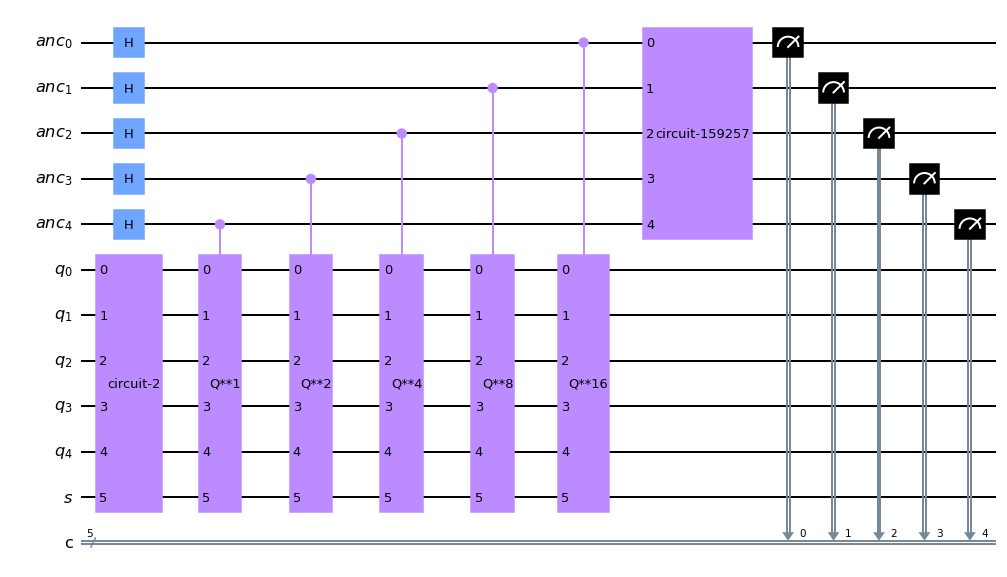

In [23]:
n = 5
m = 5

qreg = QuantumRegister(n, 'q')
creg = ClassicalRegister(m,'c')
qsum = QuantumRegister(1, 's')
qanc = AncillaRegister(m, 'anc')
qc = QuantumCircuit(qanc, qreg, qsum, creg)

qc.append(state_preparation, qreg[:]+qsum[:])

qc.h(qanc)

Q = groverOp(state_preparation, n)

for j in range(m):
    Qj = Q.power(2**j).to_gate().control(1)
    qc.append(Qj, [qanc[m-1-j]] + qreg[:] + qsum[:])

qc.append(iqft_b(m), qanc)
qc.measure(qanc,creg)

qc.draw('mpl')

In [48]:
sim_backend = Aer.get_backend('qasm_simulator')
nsim = 2**10
res = execute(qc, sim_backend, shots=nsim).result()
counts = res.get_counts()
sample = []
freq = []
for k,v in counts.items():
    theta_a = np.pi * int(k,2) / 2**m
    a = np.sin(theta_a)**2
    sample.append(a)
    freq.append(v/nsim)
print(sample)
print(freq)
print(counts)
print(sample[freq.index(max(freq))]*5)

[0.597545161008064, 0.6913417161825449, 0.691341716182545, 0.8535533905932737, 0.9903926402016151, 0.5975451610080643, 0.0, 0.777785116509801, 0.9619397662556434, 0.7777851165098012, 0.40245483899193585, 0.5000000000000001, 0.8535533905932737, 0.40245483899193585, 0.5000000000000001, 0.9157348061512728, 0.3086582838174551, 0.14644660940672624, 0.08426519384872735, 0.14644660940672632, 0.009607359798384776, 0.9157348061512728, 0.22221488349019888, 0.22221488349019905]
[0.0341796875, 0.421875, 0.4423828125, 0.00390625, 0.0009765625, 0.025390625, 0.0029296875, 0.015625, 0.0029296875, 0.0126953125, 0.00390625, 0.0029296875, 0.0048828125, 0.001953125, 0.0068359375, 0.001953125, 0.0009765625, 0.0029296875, 0.001953125, 0.001953125, 0.0009765625, 0.00390625, 0.0009765625, 0.0009765625]
{'01001': 35, '01010': 432, '10110': 453, '10100': 4, '01111': 1, '10111': 26, '00000': 3, '01011': 16, '10010': 3, '10101': 13, '11001': 4, '01000': 3, '01100': 5, '00111': 2, '11000': 7, '01101': 2, '00110': 

In [82]:
from qiskit.algorithms.amplitude_estimators.ae_utils import pdf_a, bisect_max

def compute_mle(m, counts, shots):
    M = 2 ** m  # pylint: disable=invalid-name
    
    def prob(k):
        return np.sin(np.pi * k / M)**2

    samples = {}
    for k,v in counts.items():
        samples[prob(int(k,2))] = v/shots
    print(samples)
        
    
    qae = max(samples, key=samples.get)
    
    # likelihood function
    a_i = np.asarray(list(samples.keys()))
    p_i = np.asarray(list(samples.values()))

    def loglikelihood(a):
        return np.sum(shots * p_i * np.log(pdf_a(a_i, a, m)))

    # y is pretty much an integer, but to map 1.9999 to 2 we must first
    # use round and then int conversion
    
    #y = int(max(counts, key=counts.get),2)#int(np.round(M * np.arcsin(np.sqrt(qae)) / np.pi))
    #print(y)
    y = int(np.round(M * np.arcsin(np.sqrt(qae)) / np.pi))
    #print(y)
    # Compute the two intervals in which are candidates for containing
    # the maximum of the log-likelihood function: the two bubbles next to
    # the QAE estimate
    if y == 0:
        right_of_qae = np.sin(np.pi * (y + 1) / M) ** 2
        bubbles = [qae, right_of_qae]

    elif y == int(M / 2):  # remember, M = 2^m is a power of 2
        left_of_qae = np.sin(np.pi * (y - 1) / M) ** 2
        bubbles = [left_of_qae, qae]

    else:
        left_of_qae = np.sin(np.pi * (y - 1) / M) ** 2
        right_of_qae = np.sin(np.pi * (y + 1) / M) ** 2
        bubbles = [left_of_qae, qae, right_of_qae]

    # Find global maximum amongst the two local maxima
    a_opt = qae
    loglik_opt = loglikelihood(a_opt)
    for a, b in zip(bubbles[:-1], bubbles[1:]):
        locmax, val = bisect_max(loglikelihood, a, b, retval=True)
        if val > loglik_opt:
            a_opt = locmax
            loglik_opt = val

    return qae, a_opt

In [83]:
[a*5 for a in compute_mle(m,counts,nsim)]

{0.597545161008064: 0.0341796875, 0.6913417161825449: 0.421875, 0.691341716182545: 0.4423828125, 0.8535533905932737: 0.0048828125, 0.9903926402016151: 0.0009765625, 0.5975451610080643: 0.025390625, 0.0: 0.0029296875, 0.777785116509801: 0.015625, 0.9619397662556434: 0.0029296875, 0.7777851165098012: 0.0126953125, 0.40245483899193585: 0.001953125, 0.5000000000000001: 0.0068359375, 0.9157348061512728: 0.00390625, 0.3086582838174551: 0.0009765625, 0.14644660940672624: 0.0029296875, 0.08426519384872735: 0.001953125, 0.14644660940672632: 0.001953125, 0.009607359798384776: 0.0009765625, 0.22221488349019888: 0.0009765625, 0.22221488349019905: 0.0009765625}


[3.456708580912725, 3.3650779436317557]

In [51]:
from qiskit.algorithms import AmplitudeEstimation

ae = AmplitudeEstimation(
    num_eval_qubits=m,  # the number of evaluation qubits specifies circuit width and accuracy
    quantum_instance=quantum_instance,
)

ae_result = ae.estimate(problem)

#validation, raw and ml estimate match!
print(ae_result.estimation*n, ae_result.mle*n)

3.4567084999999995 3.368798974848618


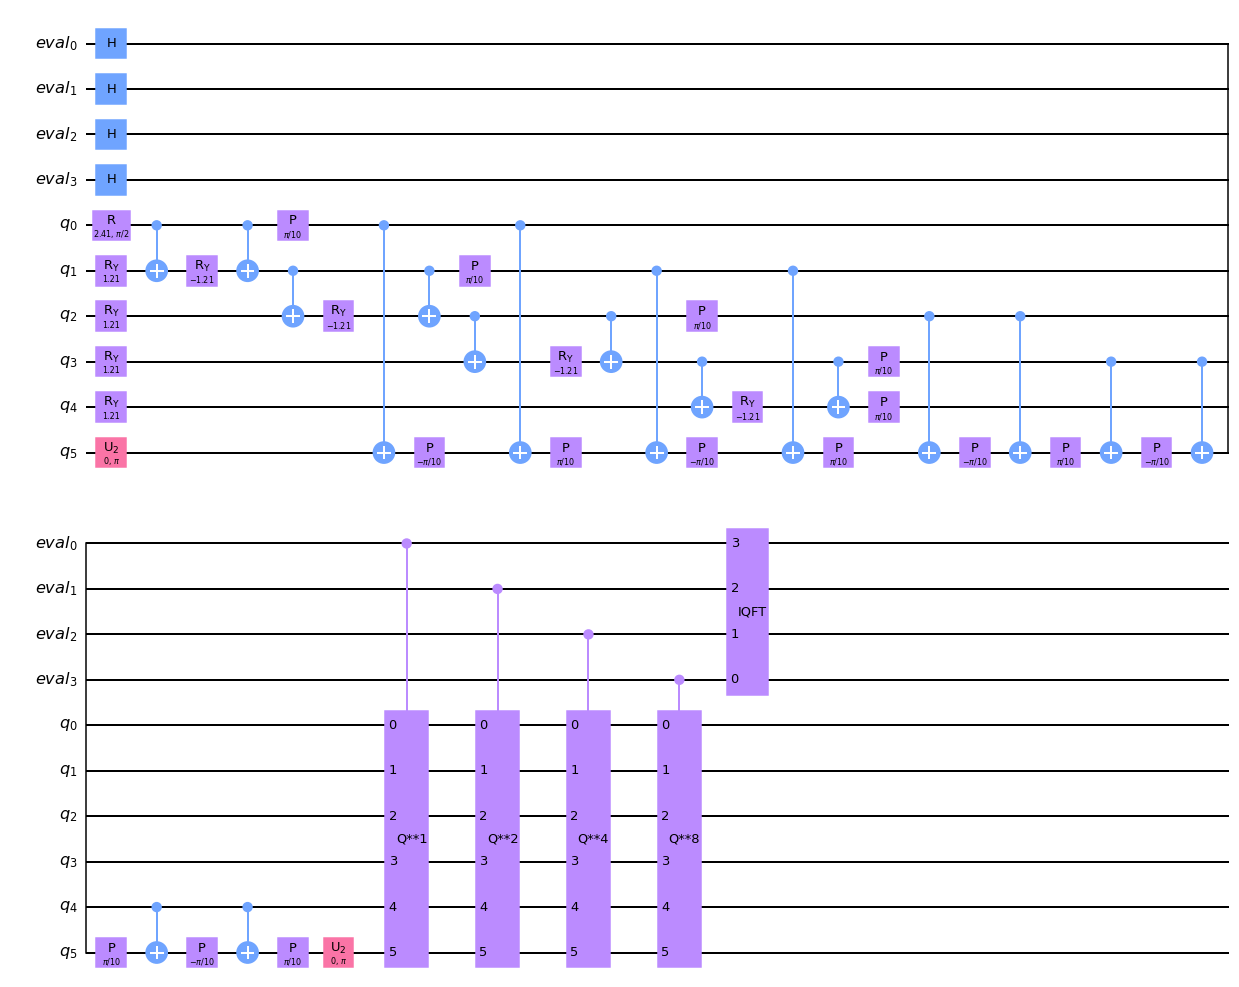

In [22]:
#validation, circuits match!
ae.construct_circuit(problem).decompose().draw('mpl')